In [1250]:
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import StandardScaler


catapult = pd.read_csv("michigan-catapult-data.csv")
game_data = pd.read_csv("ncaa-michigan-game-data.csv")
season_data = pd.read_csv("ncaa-michigan-season-data.csv")

# Cleaning/formatting the catapult data

In [1251]:
catapult.columns = catapult.columns.str.replace(' ', '')

In [1252]:
# Deleting rows that players have 0 duration
indexNames = catapult[catapult['TotalDuration'] == '0:00:00'].index
catapult.drop(indexNames , inplace=True)

In [1253]:
# Converting DateTime format
catapult['Date'] = pd.to_datetime(catapult['Date'])

In [1254]:
activities = catapult.PeriodName
my_list = []
for act in activities:
    act = act.lower()
    if re.search(r'game|activity|practice', act):
        my_list.append(True)
    else:
        my_list.append(False)
        
catapult['filter'] = my_list
indexNames = catapult[catapult['filter'] == False].index
catapult.drop(indexNames , inplace=True)

In [1255]:
activities = catapult.PeriodName

my_list = []
for act in activities:
    act = act.lower()
    if re.search(r'game', act):
        my_list.append("game")
        continue
    if re.search(r'practice', act):
        my_list.append("practice")
        continue
    if re.search(r'activity', act):
        my_list.append("activity")
        continue
    else:
        continue
        
catapult['type'] = my_list
del catapult['filter']

In [1256]:
# Converting the lengths of time to decimals

total = catapult.TotalDuration
times = []
for t in total:
    (h, m, s) = t.split(':')
    result = int(h) * 3600 + int(m) * 60 + int(s)
    times.append(result)
catapult['TotalDuration'] = times

total = catapult.TotalInstructional
times = []
for t in total:
    (h, m, s) = t.split(':')
    result = int(h) * 3600 + int(m) * 60 + int(s)
    times.append(result)
catapult['TotalInstructional'] = times

total = catapult.LowIntensityMovement
times = []
for t in total:
    (h, m, s) = t.split(':')
    result = int(h) * 3600 + int(m) * 60 + int(s)
    times.append(result)
catapult['LowIntensityMovement'] = times

total = catapult.PlayerLoadBand3TotalDuration
times = []
for t in total:
    (h, m, s) = t.split(':')
    result = int(h) * 3600 + int(m) * 60 + int(s)
    times.append(result)
catapult['PlayerLoadBand3TotalDuration'] = times

total = catapult.PlayerLoadBand4TotalDuration
times = []
for t in total:
    (h, m, s) = t.split(':')
    result = int(h) * 3600 + int(m) * 60 + int(s)
    times.append(result)
catapult['PlayerLoadBand4TotalDuration'] = times

In [1257]:
catapult17 = catapult.copy()
start_date = '2016-09-06'
end_date = '2017-05-06'
mask = (catapult17['Date'] > start_date) & (catapult17['Date'] <= end_date)
catapult17 = catapult17.loc[mask]

catapult18 = catapult.copy()
start_date = '2017-08-06'
end_date = '2018-05-06'
mask = (catapult18['Date'] > start_date) & (catapult18['Date'] <= end_date)
catapult18 = catapult18.loc[mask]

In [1258]:
catapult_means = catapult.groupby(['Date','type','PositionName']).mean().add_suffix('_avg').reset_index()

# Cleaning/formatting the game data

In [1259]:
date_time = game_data.gametime

dates = [x[:-14] for x in date_time]
times = [x[-14:-6] for x in date_time]

game_data['date'] = dates
game_data['time'] = times

game_data['date'] = pd.to_datetime(game_data['date'])
game_data['time'] = pd.to_datetime(game_data['time'])
del game_data['gametime']

x = game_data.time

new_times = [times.time().strftime('%H:%M:%S') for times in x]
game_data['time'] = new_times

game_data['scheduled_date'] = pd.to_datetime(game_data['scheduled_date'])

In [1260]:
game_data2017 = game_data.copy()
mask = (game_data['season'] == 2017)
game_data2017 = game_data.loc[mask]

game_data2018 = game_data.copy()
mask = (game_data['season'] == 2018)
game_data2018 = game_data.loc[mask]

# Catapult Practice PCA

In [1261]:
catapult17_practice = catapult17.copy()
mask = (catapult17['type'] == 'practice') | (catapult17['type'] == 'activity')
catapult17_practice = catapult17.loc[mask]
del catapult17_practice['Unnamed:0']
del catapult17_practice['PlayerID']
del catapult17_practice['PeriodName']
del catapult17_practice['PositionName']
dates_2017 = catapult17_practice['Date']
del catapult17_practice['Date']
del catapult17_practice['DayName']
del catapult17_practice['StartTime']
del catapult17_practice['EndTime']
del catapult17_practice['type']

catapult18_practice = catapult18.copy()
mask = (catapult18['type'] == 'practice') | (catapult18['type'] == 'activity')
catapult18_practice = catapult18.loc[mask]
del catapult18_practice['Unnamed:0']
del catapult18_practice['PlayerID']
del catapult18_practice['PeriodName']
del catapult18_practice['PositionName']
dates_2018 = catapult18_practice['Date']
del catapult18_practice['Date']
del catapult18_practice['DayName']
del catapult18_practice['StartTime']
del catapult18_practice['EndTime']
del catapult18_practice['type']

In [1262]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
catapult17_scaled = scaler.fit_transform(catapult17_practice)
catapult18_scaled = scaler.fit_transform(catapult18_practice)

In [1263]:
feat_cols = ['feature'+str(i) for i in range(catapult17_scaled.shape[1])]
catapult17_scaled = pd.DataFrame(catapult17_scaled,columns=feat_cols)
feat_cols = ['feature'+str(i) for i in range(catapult18_scaled.shape[1])]
catapult18_scaled = pd.DataFrame(catapult18_scaled,columns=feat_cols)

from sklearn.decomposition import PCA

pca_catapult_17 = PCA(n_components=1)
pca_catapult_18 = PCA(n_components=1)
principalComponents_catapult_17 = pca_catapult_17.fit_transform(catapult17_scaled)
principalComponents_catapult_18 = pca_catapult_18.fit_transform(catapult18_scaled)

In [1264]:
print('Explained variation per principal component Practice 2017: {}'.format(pca_catapult_17.explained_variance_ratio_))
print('Explained variation per principal component Practice 2018: {}'.format(pca_catapult_18.explained_variance_ratio_))

Explained variation per principal component Practice 2017: [0.71603485]
Explained variation per principal component Practice 2018: [0.7730392]


In [1265]:
catapult17_practice['pca'] = principalComponents_catapult_17
catapult17_practice['Date'] = dates_2017

catapult18_practice['pca'] = principalComponents_catapult_18
catapult18_practice['Date'] = dates_2018

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

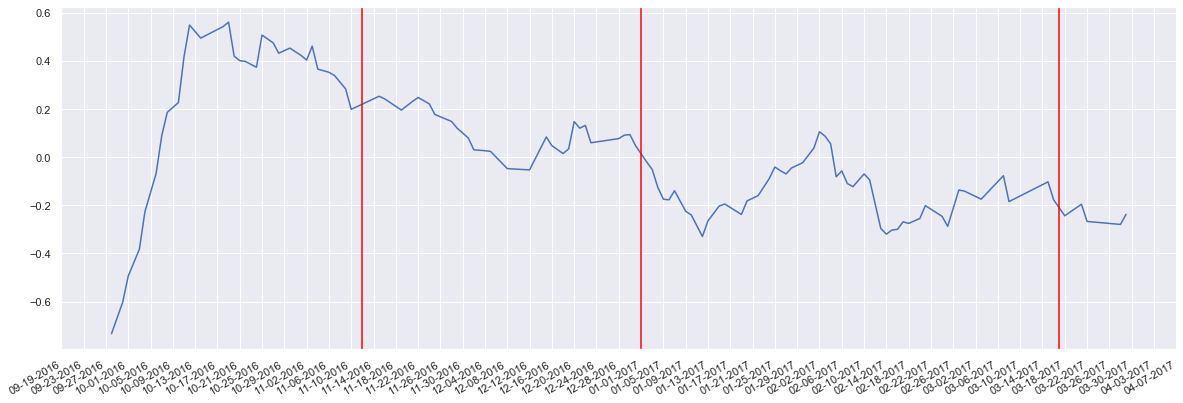

In [1266]:
catapult17_practice = catapult17_practice.groupby(['Date']).mean().reset_index()
catapult18_practice = catapult18_practice.groupby(['Date']).mean().reset_index()

fig = plt.figure(figsize=(20,7))
rolling_mean2 = catapult17_practice.pca.rolling(window=10).mean()
ax = fig.add_subplot(111)
date_form = DateFormatter("%m-%d-%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))

ax.plot(catapult17_practice.Date, rolling_mean2)
plt.axvline(x='2016-11-12', color='red')
plt.axvline(x='2017-01-01', color='red')
plt.axvline(x='2017-03-17', color='red')
fig.autofmt_xdate()
ax.grid(True)
plt.savefig('pca2017Practice.png')

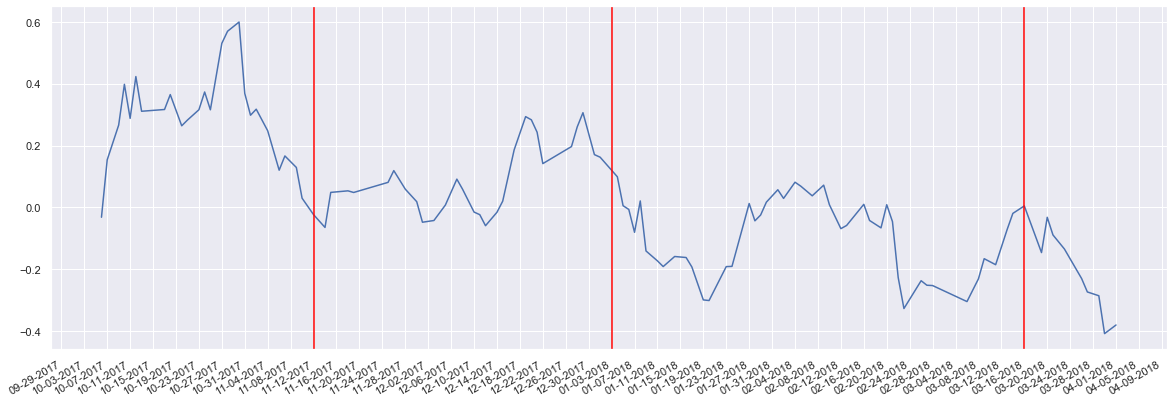

In [1267]:
fig = plt.figure(figsize=(20,7))
rolling_mean2 = catapult18_practice.pca.rolling(window=10).mean()
ax = fig.add_subplot(111)
date_form = DateFormatter("%m-%d-%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))

ax.plot(catapult18_practice.Date, rolling_mean2)
plt.axvline(x='2017-11-12', color='red')
plt.axvline(x='2018-01-03', color='red')
plt.axvline(x='2018-03-16', color='red')
fig.autofmt_xdate()
ax.grid(True)
plt.savefig('pca2018Practice.png')

# Catapult Game PCA

In [1268]:
catapult17_game = catapult17.copy()
mask = (catapult17['type'] == 'game')
catapult17_game = catapult17.loc[mask]
del catapult17_game['Unnamed:0']
del catapult17_game['PlayerID']
del catapult17_game['PeriodName']
del catapult17_game['PositionName']
dates_2017 = catapult17_game['Date']
del catapult17_game['Date']
del catapult17_game['DayName']
del catapult17_game['StartTime']
del catapult17_game['EndTime']
del catapult17_game['type']

catapult18_game = catapult18.copy()
mask = (catapult18['type'] == 'game')
catapult18_practice = catapult18.loc[mask]
del catapult18_game['Unnamed:0']
del catapult18_game['PlayerID']
del catapult18_game['PeriodName']
del catapult18_game['PositionName']
dates_2018 = catapult18_game['Date']
del catapult18_game['Date']
del catapult18_game['DayName']
del catapult18_game['StartTime']
del catapult18_game['EndTime']
del catapult18_game['type']

In [1269]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
catapult17_scaled = scaler.fit_transform(catapult17_game)
catapult18_scaled = scaler.fit_transform(catapult18_game)

In [1270]:
feat_cols = ['feature'+str(i) for i in range(catapult17_scaled.shape[1])]
catapult17_scaled = pd.DataFrame(catapult17_scaled,columns=feat_cols)
feat_cols = ['feature'+str(i) for i in range(catapult18_scaled.shape[1])]
catapult18_scaled = pd.DataFrame(catapult18_scaled,columns=feat_cols)

from sklearn.decomposition import PCA

pca_catapult_17 = PCA(n_components=1)
pca_catapult_18 = PCA(n_components=1)
principalComponents_catapult_17 = pca_catapult_17.fit_transform(catapult17_scaled)
principalComponents_catapult_18 = pca_catapult_18.fit_transform(catapult18_scaled)

In [1271]:
print('Explained variation per principal component Game 2017: {}'.format(pca_catapult_17.explained_variance_ratio_))
print('Explained variation per principal component Game 2018: {}'.format(pca_catapult_18.explained_variance_ratio_))

Explained variation per principal component Game 2017: [0.77391853]
Explained variation per principal component Game 2018: [0.75172889]


In [1272]:
catapult17_game['pca'] = principalComponents_catapult_17
catapult17_game['Date'] = dates_2017

catapult18_game['pca'] = principalComponents_catapult_18
catapult18_game['Date'] = dates_2018

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



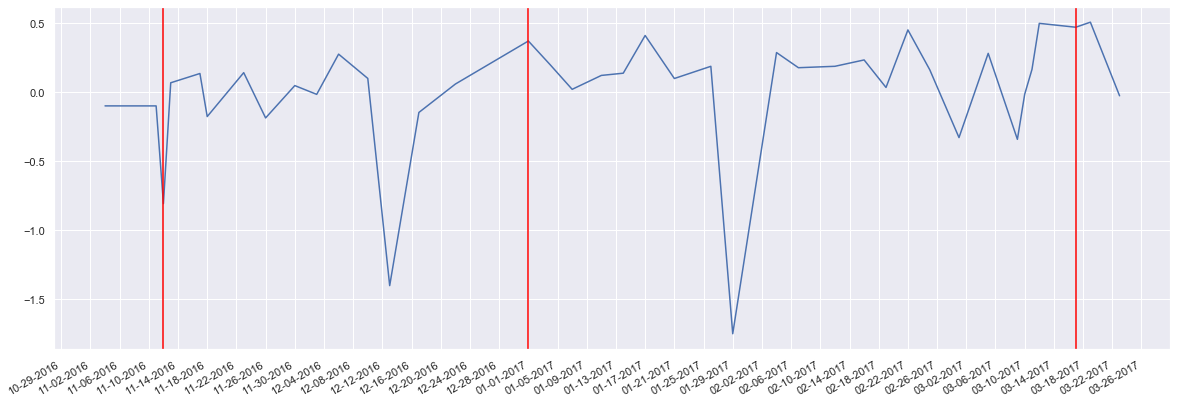

In [1273]:
catapult17_game = catapult17_game.groupby(['Date']).mean().reset_index()
catapult18_game = catapult18_game.groupby(['Date']).mean().reset_index()

fig = plt.figure(figsize=(20,7))
# rolling_mean2 = catapult17_game.pca.rolling(window=10).mean()
ax = fig.add_subplot(111)
date_form = DateFormatter("%m-%d-%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))

ax.plot(catapult17_game['Date'], catapult17_game['pca'])
plt.axvline(x='2016-11-12', color='red')
plt.axvline(x='2017-01-01', color='red')
plt.axvline(x='2017-03-17', color='red')
fig.autofmt_xdate()
ax.grid(True)
plt.savefig('pca2017Game.png')

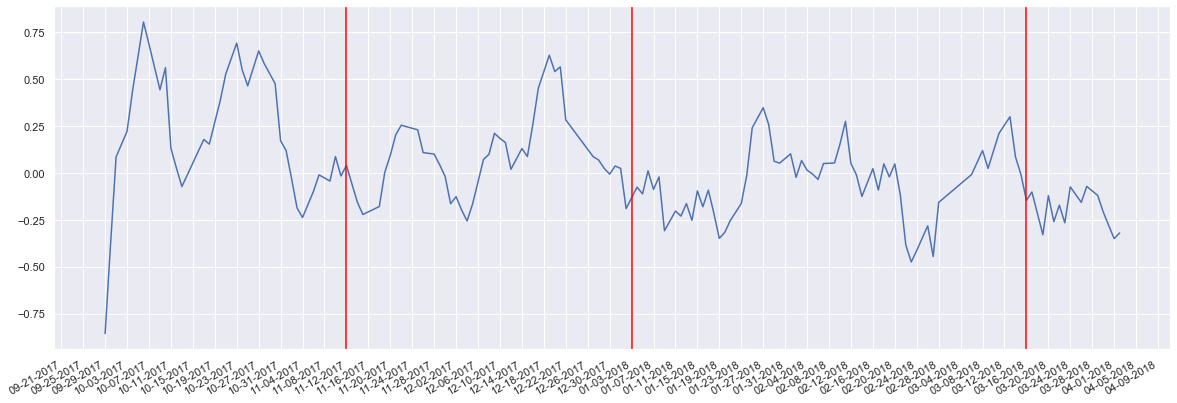

In [1274]:
fig = plt.figure(figsize=(20,7))
rolling_mean2 = catapult18_game.pca.rolling(window=5).mean()
ax = fig.add_subplot(111)
date_form = DateFormatter("%m-%d-%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))

ax.plot(catapult18_game.Date, rolling_mean2)
plt.axvline(x='2017-11-12', color='red')
plt.axvline(x='2018-01-03', color='red')
plt.axvline(x='2018-03-16', color='red')
fig.autofmt_xdate()
ax.grid(True)
plt.savefig('pca2018Game.png')

# A brief detour to looking at duration instead of intensity

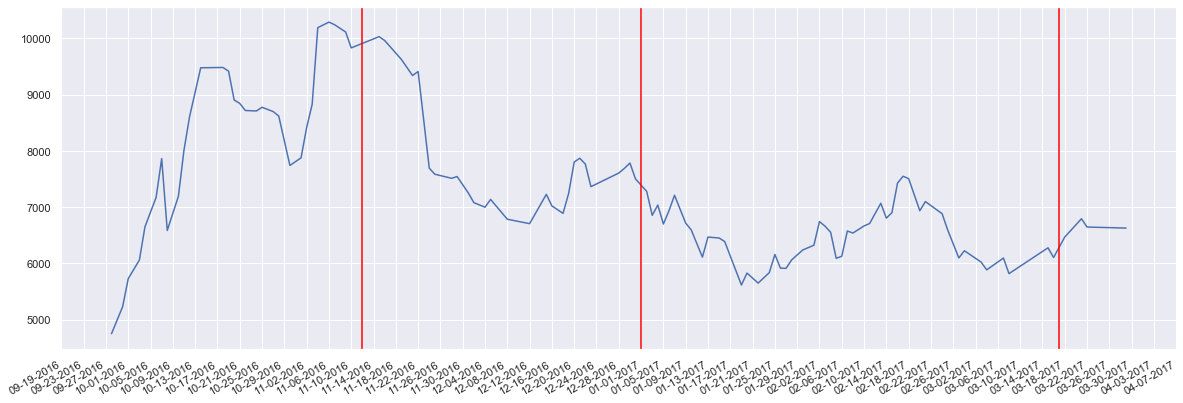

In [1275]:
# Practice time appears to follow same trends as intensity
fig = plt.figure(figsize=(20,7))
rolling_mean2 = catapult17_practice.TotalDuration.rolling(window=10).mean()
ax = fig.add_subplot(111)
date_form = DateFormatter("%m-%d-%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))

ax.plot(catapult17_practice.Date, rolling_mean2)
plt.axvline(x='2016-11-12', color='red')
plt.axvline(x='2017-01-01', color='red')
plt.axvline(x='2017-03-17', color='red')
fig.autofmt_xdate()
ax.grid(True)
plt.savefig('pca2017Practice.png')

# Looking at game dynamics data

In [1276]:
game_data2017 = game_data.copy()
mask = (game_data['season'] == 2017)
game_data2017 = game_data.loc[mask]
game_data2017 = game_data2017.fillna(0)
personal_fouls2017 = game_data2017.personal_fouls
turnovers2017 = game_data2017.turnovers

game_data2018 = game_data.copy()
mask = (game_data['season'] == 2018)
game_data2018 = game_data.loc[mask]
game_data2018 = game_data2018.fillna(0)
personal_fouls2018 = game_data2018.personal_fouls
turnovers2018 = game_data2018.turnovers

In [1277]:
del game_data2017['game_id']
del game_data2017['season']
del game_data2017['conference_game']
del game_data2017['tournament']
del game_data2017['tournament_type']
del game_data2017['tournament_round']
del game_data2017['tournament_game_no']
del game_data2017['periods']
del game_data2017['venue_city']
del game_data2017['venue_state']
del game_data2017['venue_name']
del game_data2017['home_team']
del game_data2017['name']
del game_data2017['market']
del game_data2017['team_id']
del game_data2017['alias']
del game_data2017['league_id']
del game_data2017['league_name']
del game_data2017['league_alias']
del game_data2017['conf_id']
del game_data2017['conf_name']
del game_data2017['conf_alias']
del game_data2017['division_id']
del game_data2017['division_name']
del game_data2017['division_alias']
del game_data2017['opp_name']
del game_data2017['opp_market']
del game_data2017['opp_id']
del game_data2017['opp_alias']
del game_data2017['opp_league_id']
del game_data2017['opp_league_name']
del game_data2017['opp_league_alias']
del game_data2017['opp_conf_id']
del game_data2017['opp_conf_name']
del game_data2017['opp_conf_alias']
del game_data2017['opp_division_id']
del game_data2017['opp_division_name']
del game_data2017['opp_division_alias']
del game_data2017['win']
del game_data2017['points_game']
dates_2017 = game_data2017['date']
del game_data2017['date']
del game_data2017['time']
del game_data2017['minutes']
del game_data2017['possession_arrow']
del game_data2017['opp_minutes']

del game_data2018['game_id']
del game_data2018['season']
del game_data2018['conference_game']
del game_data2018['tournament']
del game_data2018['tournament_type']
del game_data2018['tournament_round']
del game_data2018['tournament_game_no']
del game_data2018['periods']
del game_data2018['venue_city']
del game_data2018['venue_state']
del game_data2018['venue_name']
del game_data2018['home_team']
del game_data2018['name']
del game_data2018['market']
del game_data2018['team_id']
del game_data2018['alias']
del game_data2018['league_id']
del game_data2018['league_name']
del game_data2018['league_alias']
del game_data2018['conf_id']
del game_data2018['conf_name']
del game_data2018['conf_alias']
del game_data2018['division_id']
del game_data2018['division_name']
del game_data2018['division_alias']
del game_data2018['opp_name']
del game_data2018['opp_market']
del game_data2018['opp_id']
del game_data2018['opp_alias']
del game_data2018['opp_league_id']
del game_data2018['opp_league_name']
del game_data2018['opp_league_alias']
del game_data2018['opp_conf_id']
del game_data2018['opp_conf_name']
del game_data2018['opp_conf_alias']
del game_data2018['opp_division_id']
del game_data2018['opp_division_name']
del game_data2018['opp_division_alias']
del game_data2018['win']
del game_data2018['points_game']
dates_2018 = game_data2018['date']
del game_data2018['date']
del game_data2018['time']
del game_data2018['minutes']
del game_data2018['possession_arrow']
del game_data2018['opp_minutes']

In [1278]:
game_data2017 = game_data2017[['field_goals_pct','three_points_pct', 'two_points_pct', 'free_throws_pct', 'rebounds', 'assists', 'steals', 'blocks', 'fast_break_pts', 'second_chance_pts', 'points_off_turnovers']]
game_data2018 = game_data2018[['field_goals_pct','three_points_pct', 'two_points_pct', 'free_throws_pct', 'rebounds', 'assists', 'steals', 'blocks', 'fast_break_pts', 'second_chance_pts', 'points_off_turnovers']]

In [1279]:
game_data2017.loc[:,'total'] = game_data2017.sum(axis=1)
game_data2018.loc[:,'total'] = game_data2018.sum(axis=1)

In [1280]:
total = game_data2017.total
total = total - personal_fouls2017 - turnovers2017
game_data2017['totals'] = total
game_data2017['date'] = dates_2017

total = game_data2018.total
total = total - personal_fouls2018 - turnovers2018
game_data2018['totals'] = total
game_data2018['date'] = dates_2018

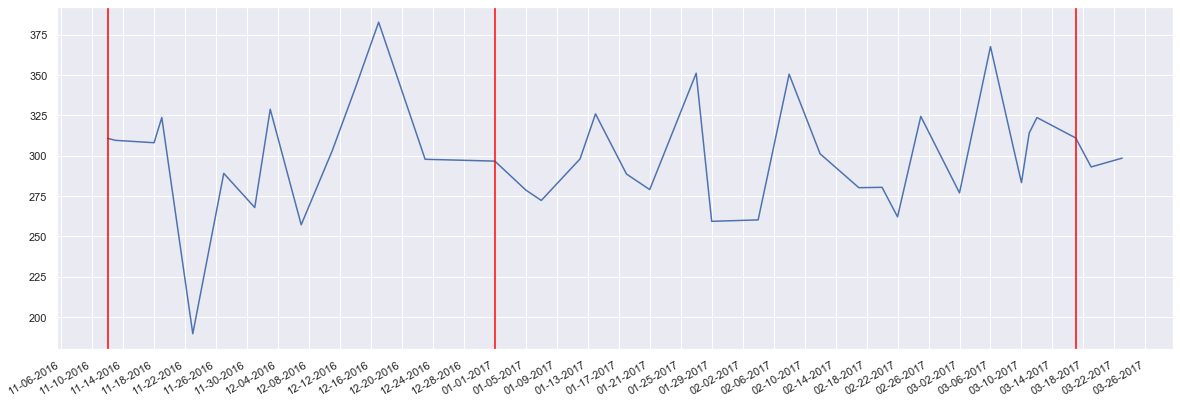

In [1281]:
fig = plt.figure(figsize=(20,7))
# rolling_mean2 = catapult18_game.pca.rolling(window=5).mean()
ax = fig.add_subplot(111)
date_form = DateFormatter("%m-%d-%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))

ax.plot(game_data2017['date'], game_data2017['total'])
plt.axvline(x='2016-11-12', color='red')
plt.axvline(x='2017-01-01', color='red')
plt.axvline(x='2017-03-17', color='red')
fig.autofmt_xdate()
ax.grid(True)
plt.savefig('2017dyamics.png')

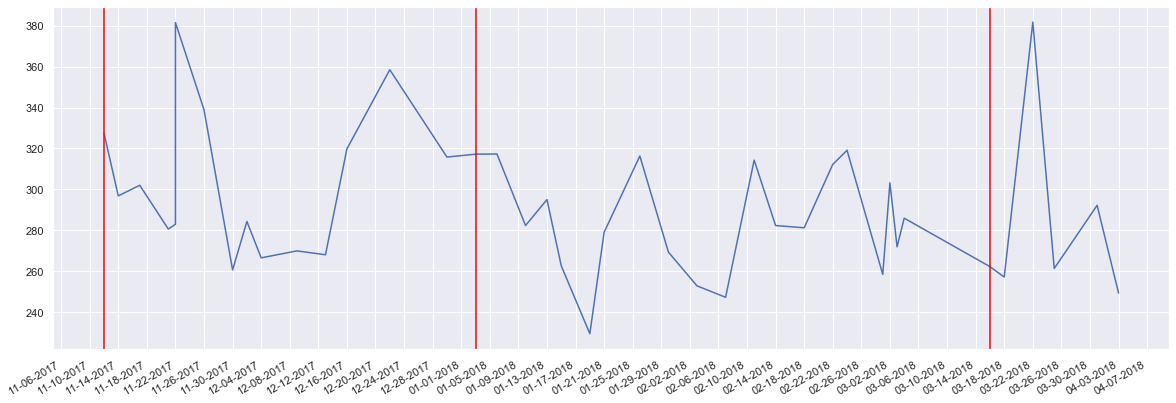

In [1282]:
fig = plt.figure(figsize=(20,7))
# rolling_mean2 = catapult18_game.pca.rolling(window=5).mean()
ax = fig.add_subplot(111)
date_form = DateFormatter("%m-%d-%Y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))

ax.plot(game_data2018['date'], game_data2018['total'])
plt.axvline(x='2017-11-12', color='red')
plt.axvline(x='2018-01-03', color='red')
plt.axvline(x='2018-03-16', color='red')
fig.autofmt_xdate()
ax.grid(True)
plt.savefig('2018dyamics.png')